# Geometric Distribution

In [1]:
using Gen
using PyPlot
using Distributions

## Define a geometric distribution model

In [2]:
@gen function my_geometric(p::Float64)
    
    x = 0
    while true
        z = @trace(Gen.bernoulli(p), :z => x)
        if !z
            x += 1
        else
            return x
        end
    end
    
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Float64], ##my_geometric#371, Bool[0], false)

## Look at a trace

In [15]:
trace = Gen.simulate(my_geometric, (0.25,));
println("Inputs: ", get_args(trace))
println(get_choices(trace))
println("Return value: ", get_retval(trace), "\nprob: ", exp(get_score(trace)))

Inputs: (0.25,)
│
└── :z
    │
    ├── 0 : false
    │
    ├── 4 : false
    │
    ├── 7 : false
    │
    ├── 2 : false
    │
    ├── 3 : false
    │
    ├── 5 : false
    │
    ├── 8 : true
    │
    ├── 6 : false
    │
    └── 1 : false

Return value: 8
prob: 0.025028228759765646


## Model the entire data generating process

We wrote a model for a _single_ geometric variable.

Our dataset will consist of _many_ geometric variables.

In [16]:
@gen function full_model(n_samples)
    
    # Prior distribution for p
    p = @trace(Gen.beta(1.0,1.0), :p)
    
    # Generate the geometric samples
    xs = zeros(Int64, n_samples)
    for i=1:n_samples
        xs[i] = @trace(my_geometric(p), :x => i)
    end
    
    return xs
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any], ##full_model#372, Bool[0], false)

In [17]:
full_trace = Gen.simulate(full_model, (100,));
println(get_choices(full_trace))

│
├── :p : 0.4358382073235005
│
└── :x
    │
    ├── 68
    │   │
    │   └── :z
    │       │
    │       ├── 0 : false
    │       │
    │       ├── 2 : true
    │       │
    │       └── 1 : false
    │
    ├── 2
    │   │
    │   └── :z
    │       │
    │       └── 0 : true
    │
    ├── 89
    │   │
    │   └── :z
    │       │
    │       ├── 0 : false
    │       │
    │       └── 1 : true
    │
    ├── 11
    │   │
    │   └── :z
    │       │
    │       └── 0 : true
    │
    ├── 39
    │   │
    │   └── :z
    │       │
    │       ├── 0 : false
    │       │
    │       └── 1 : true
    │
    ├── 46
    │   │
    │   └── :z
    │       │
    │       └── 0 : true
    │
    ├── 85
    │   │
    │   └── :z
    │       │
    │       ├── 0 : false
    │       │
    │       └── 1 : true
    │
    ├── 25
    │   │
    │   └── :z
    │       │
    │       └── 0 : true
    │
    ├── 55
    │   │
    │   └── :z
    │       │
    │       └── 0 : true
    │
    ├── 42
    │   │
    │ 

## Make some data to play with

We'll set a "hidden" parameter $p=0.375$.

In [18]:
hidden_p = 0.375
n_data = 200
dataset = rand(Distributions.Geometric(hidden_p), n_data)
println(dataset)

[2, 3, 1, 1, 1, 2, 2, 1, 2, 0, 2, 0, 2, 2, 0, 0, 4, 0, 1, 0, 1, 1, 4, 4, 2, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 3, 2, 1, 0, 2, 0, 0, 4, 0, 5, 0, 1, 0, 4, 0, 0, 3, 4, 0, 1, 6, 2, 1, 1, 0, 8, 2, 0, 3, 1, 0, 0, 1, 1, 11, 0, 1, 2, 4, 3, 3, 1, 3, 2, 1, 0, 1, 0, 1, 0, 2, 1, 2, 2, 1, 2, 0, 0, 2, 0, 3, 0, 0, 0, 1, 0, 0, 4, 1, 5, 1, 2, 0, 3, 2, 0, 0, 0, 4, 3, 0, 0, 6, 0, 0, 1, 2, 4, 0, 0, 0, 1, 0, 1, 0, 0, 10, 1, 3, 0, 1, 1, 1, 1, 0, 7, 1, 2, 0, 0, 2, 1, 3, 2, 1, 2, 0, 3, 0, 2, 3, 4, 5, 0, 5, 0, 1, 0, 3, 4, 2, 3, 2, 1, 4, 2, 0, 0, 0, 2, 0, 2, 5, 5, 0, 5, 2, 0, 4, 0, 0, 11, 0, 0, 0, 0, 1, 0, 1, 2, 5, 1, 0]


## Condition the model on the data

In [19]:
observations = Gen.choicemap()
for (i, x) in enumerate(dataset)
    for j=0:x-1
        observations[:x => i => :z => j] = false
    end
    observations[:x => i => :z => x] = true
end

## Infer a posterior for the hidden parameter, $p$

In [20]:
function inference_program(n_data, n_samples, observations)
    
    sampled_ps = zeros(n_samples)
    
    for i=1:n_samples
        tr, _ = Gen.importance_resampling(full_model, (n_data,), observations, 50)
        sampled_ps[i] = tr[:p]
    end
    
    return sampled_ps 
end

inference_program (generic function with 1 method)

In [21]:
sampled_ps = inference_program(n_data, 100, observations);

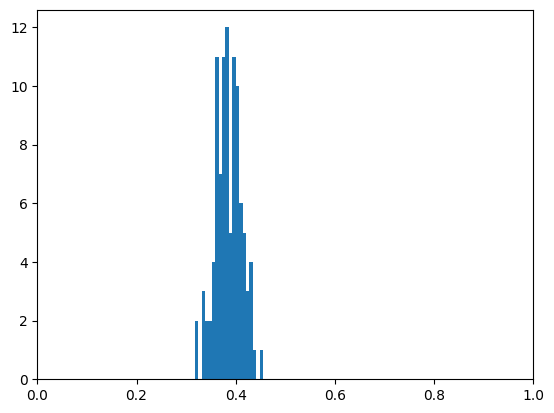

In [22]:
hist(sampled_ps, bins=20)
xlim(0.0,1.0)
show()